In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ito_diffusion_1d import *
from scipy.stats import laplace, jarque_bera
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,18),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
T = 1
SCHEME_STEPS = int(2e4)
ROLLING_WINDOW = 250

## Brownian motion, with and without drift

$dX_t = \mu dt + \sigma dW_t + dJ_t$

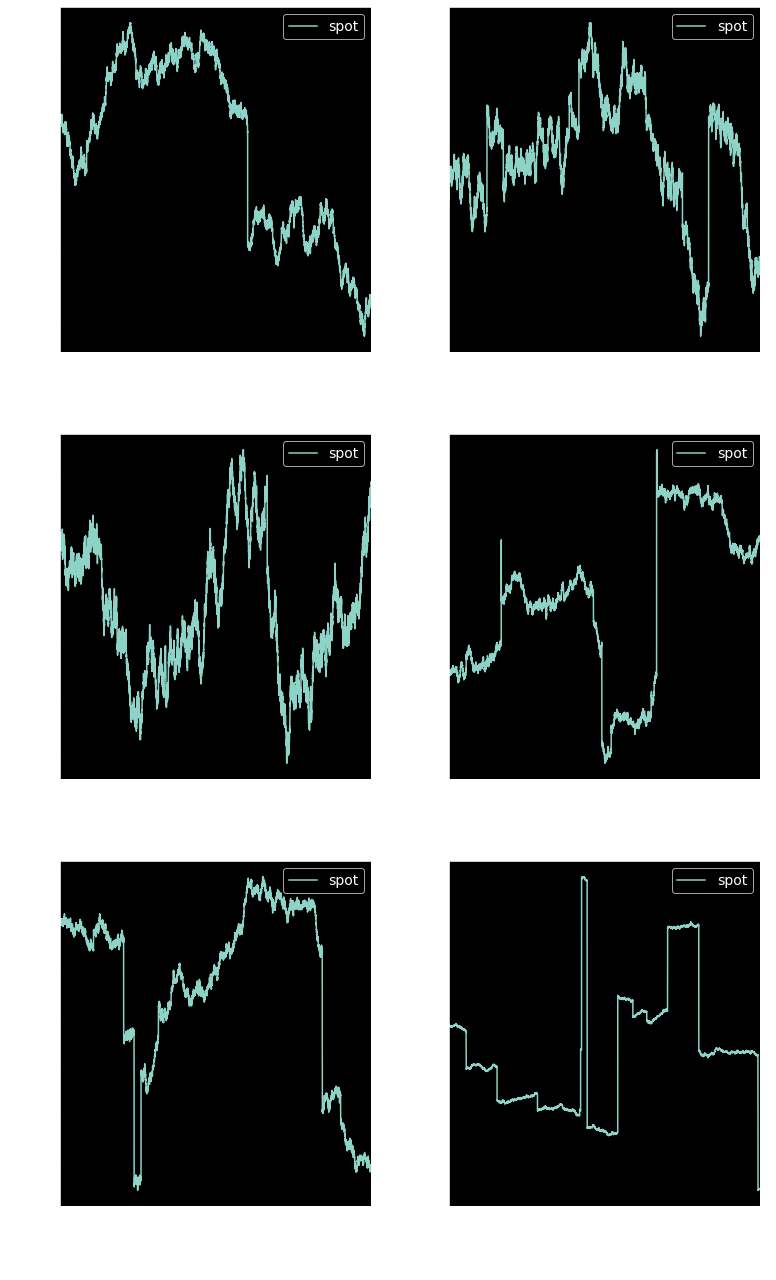

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=2)

jump_intensities = [1.0, 5.0, 10.0]
jump_size_scales = [0.1, 1.0, 5.0]

X = Levy(x0=0, T=T, scheme_steps=SCHEME_STEPS, vol=1)

for i, axes in enumerate(axes):
    ax = axes[0]
    jump_intensity = jump_intensities[i]
    jump_size_scale = 1.0
    X.jump_intensity = jump_intensity
    X.jump_size_distr = laplace(loc=0.0, scale=jump_size_scale)
    
    df = X.simulate()
    df.plot(kind='line', ax=ax)

    ax.set_xlabel('time\njump intensity={:.1f}\njump scale={:.1f}'.format(jump_intensity, jump_size_scale))
    ax.set_ylabel('spot')
    ax.legend(loc='upper right')
    
    ax = axes[1]
    X.jump_intensity = 10.0
    jump_size_scale = jump_size_scales[i]
    jump_size_distr = laplace(loc=0.0, scale=jump_size_scale)
    X.jump_size_distr = jump_size_distr
    df = X.simulate()
    df.plot(kind='line', ax=ax)

    ax.set_xlabel('time\njump intensity={:.1f}\njump scale={:.1f}'.format(jump_intensity, jump_size_scale))
    ax.set_ylabel('spot')
    ax.legend(loc='upper right')
    
plt.tight_layout()

plt.show()

## Fat-tailed returns distribution

In [5]:
jump_intensity = 5.0
jump_size_scale = 1.0

BM_gen = BM(x0=0.0, T=T, scheme_steps=SCHEME_STEPS, vol=1.0)
Levy_gen = Levy(x0=0.0, T=T, scheme_steps=SCHEME_STEPS, vol=1.0,
                jump_intensity=jump_intensity, 
                jump_size_distr=laplace(loc=0.0, scale=jump_size_scale))

In [6]:
df_BM = BM_gen.simulate()
df_Levy = Levy_gen.simulate()

inc_BM = (df_BM-df_BM.shift(1)).iloc[1:]
inc_Levy = (df_Levy-df_Levy.shift(1)).iloc[1:]

### Excess kurtosis is 0 for Gaussian series of returns, higher level implies fatter tails

In [7]:
[
    inc_BM.kurtosis()['spot'],
    inc_Levy.kurtosis()['spot'],
]

[-0.07592663061052018, 2191.590009721328]

### Jarque-Bera normality test : the higher the statistics, the more it rejects the normality hypothesis

In [8]:
[
    jarque_bera(inc_BM)[0],
    jarque_bera(inc_Levy)[0],
]

[4.841883444178102, 4003954959.360755]

### Excess kurtosis explodes when the Levy process jumps

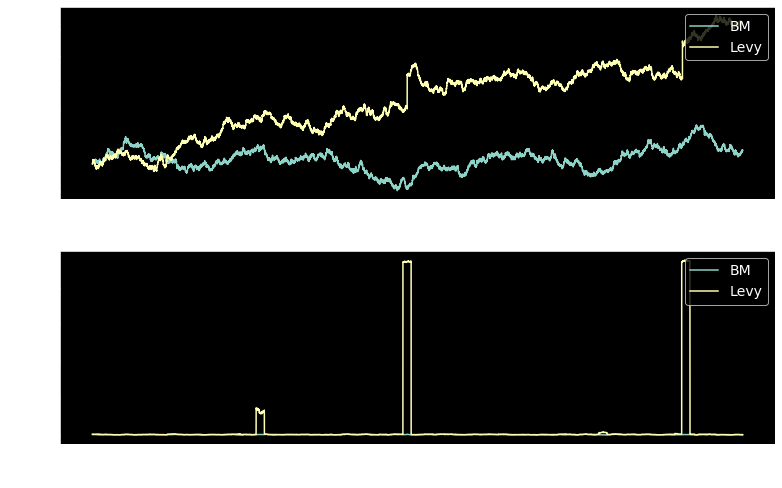

In [9]:
fig, axes = plt.subplots(figsize=(11,7), nrows=2, ncols=1)

ax = axes[0]
ax.plot(df_BM, label='BM')
ax.plot(df_Levy, label='Levy')
ax.legend(loc='upper right')
ax.set_xlabel('time')
ax.set_ylabel('data')

ax = axes[1]
ax.plot(inc_BM.rolling(ROLLING_WINDOW).kurt().dropna(), label='BM')
ax.plot(inc_Levy.rolling(ROLLING_WINDOW).kurt().dropna(), label='Levy')
ax.legend(loc='upper right')
ax.set_xlabel('time')
ax.set_ylabel('rolling kurtosis')

plt.tight_layout()
plt.show()

## Ornstein-Uhlenbeck with jumps

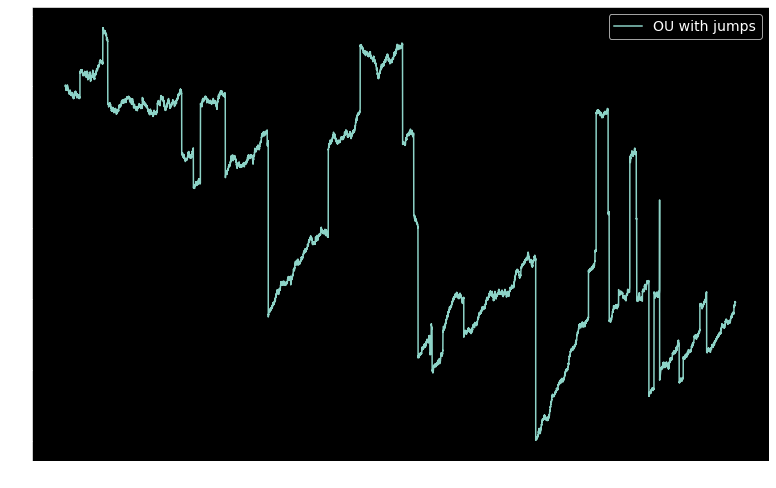

In [10]:
fig, ax = plt.subplots(figsize=(11,7), nrows=1, ncols=1)

long_term = 0.0
mean_reversion = 5.0
vol = 1.0

jump_intensity = 50.0
jump_size_scale = 1.0
jump_size_distr = laplace(loc=0.0, scale=jump_size_scale)

jump_params = {
    'jump_intensity_func': lambda t,x: jump_intensity,
    'jump_size_distr': jump_size_distr,
}

OU = Vasicek(x0=0.0, T=1, scheme_steps=SCHEME_STEPS, 
             vol=vol, long_term=long_term, mean_reversion=mean_reversion,
             jump_params=jump_params
            )

df = OU.simulate()

ax.plot(df, label='OU with jumps')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()